In [1]:
#installing pillow to access 1.2.2 version of scipy library
!pip3 install Pillow
!pip3 install scipy

In [2]:
#downgrade scipy to use misc library
!pip install scipy==1.2.2

In [3]:
#libraries imported
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy import misc
from scipy import ndimage
import scipy
import pdb 
import matplotlib.pyplot as plt
import skimage
from skimage.metrics import peak_signal_noise_ratio
import warnings
warnings.filterwarnings("ignore")

In [4]:
def imread(path, is_grayscale=True):
  """
  Read image using its path.
  Default value is gray-scale, and image is read by YCbCr format as the paper said.
  """
  if is_grayscale:
    return misc.imread(path, flatten=True, mode='YCbCr').astype(np.float32)
  else:
    return misc.imread(path, mode='YCbCr').astype(np.float32)


def modcrop(image, scale=3):
  """
  To scale down and up the original image, first thing to do is to have no remainder while scaling operation.
  
  We need to find modulo of height (and width) and scale factor.
  Then, subtract the modulo from height (and width) of original image size.
  There would be no remainder even after scaling operation.
  """
  if len(image.shape) == 3:
    h, w, _ = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w, :]
  else:
    h, w = image.shape
    h = h - np.mod(h, scale)
    w = w - np.mod(w, scale)
    image = image[0:h, 0:w]
  return image


In [5]:
def preprocess(path, scale=3):
  """
  Preprocess single image file 
    (1) Read original image as YCbCr format (and grayscale as default)
    (2) Normalize
    (3) Apply image file with bicubic interpolation
  Args:
    path: file path of desired file
    input_: image applied bicubic interpolation (low-resolution)
    label_: image with original resolution (high-resolution)
  """
  image = imread(path, is_grayscale=True)
  label_ = modcrop(image, scale)

  # Must be normalized
  label_ = label_ / 255.

  input_ = ndimage.interpolation.zoom(label_, (1./scale), prefilter=False)
  input_ = ndimage.interpolation.zoom(input_, (scale/1.), prefilter=False)

  return input_, label_

In [6]:
"""Define the model weights and biases 
"""
## ------ Add your code here: set the weight of three conv layers
# replace 'None' with your hyper parameter numbers
# conv1 layer with biases: 64 filters with size 9 x 9
# conv2 layer with biases and relu: 32 filters with size 1 x 1
# conv3 layer with biases and NO relu: 1 filter with size 5 x 5
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=9, padding=4)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=5, padding=2)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [7]:
"""Load the pre-trained model file
"""
model = SRCNN()
model.load_state_dict(torch.load('/content/model.pth'))
model.eval()

SRCNN(
  (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  (conv2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)

In [8]:
"""Read the test image
"""
LR_image, HR_image = preprocess('/content/butterfly_GT.bmp')
#transform the input to 4-D tensor
input_ = np.expand_dims(np.expand_dims(LR_image, axis=0), axis=0)
input_ = torch.from_numpy(input_)

In [9]:
"""Run the model and get the SR image
"""
with torch.no_grad():
    output_ = model(input_)

In [10]:
#Convert tensor to array
SR_image = output_.numpy()
SR_image = np.reshape(SR_image, (255, 255))

In [11]:
##------ Add your code here: save the LR and SR images and compute the psnr
# hints: use the 'scipy.misc.imsave()'  and ' skimage.metrics.peak_signal_noise_ratio()'

highres = scipy.misc.imsave('high_resolution.jpg',HR_image)

lowres = scipy.misc.imsave('low_resolution.jpg',LR_image)

supres = scipy.misc.imsave('super_resolution.jpg',SR_image)

[[0.25920767 0.25513822 0.2494797  ... 0.22881679 0.23044209 0.2311485 ]
 [0.2788774  0.2700236  0.25395328 ... 0.22590221 0.22799058 0.22887225]
 [0.3138354  0.29562753 0.25912508 ... 0.21665223 0.21967468 0.2209137 ]
 ...
 [0.2154972  0.2194135  0.2315378  ... 0.43357426 0.43390125 0.43403882]
 [0.21987672 0.22691946 0.24443674 ... 0.43563727 0.43621522 0.43647704]
 [0.22228926 0.2306639  0.25035676 ... 0.4364397  0.43717626 0.43751568]]
Low resolution image


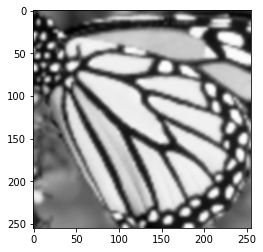

In [19]:
#plot low resolution image
print(LR_image)
#pdb.set_trace()
print("Low resolution image")
plt.imshow(LR_image,cmap='Greys_r')
plt.show()

[[0.12304706 0.17582352 0.2643843  ... 0.24218823 0.2461098  0.2343451 ]
 [0.10359216 0.1251647  0.15560001 ... 0.22901568 0.23293725 0.23775294]
 [0.2531686  0.13490589 0.10892157 ... 0.23798823 0.2419098  0.24583137]
 ...
 [0.19275686 0.20656471 0.1734902  ... 0.43803138 0.42969802 0.44169804]
 [0.17764705 0.19105098 0.20729412 ... 0.43366274 0.43754116 0.4456196 ]
 [0.17886275 0.1911804  0.2561451  ... 0.42974117 0.44864705 0.44169804]]
High resolution image


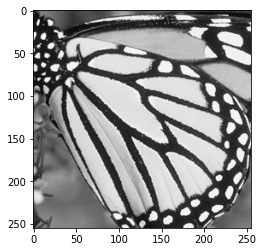

In [13]:
#plot high resolution image
print(HR_image)
#pdb.set_trace()
print("High resolution image")
plt.imshow(HR_image,cmap='Greys_r')
plt.show()

[[0.2594545  0.21442336 0.21569964 ... 0.23633996 0.22834647 0.21890654]
 [0.29000652 0.25303945 0.22742687 ... 0.2316297  0.23808499 0.23468135]
 [0.34822226 0.3417857  0.27680388 ... 0.235045   0.23636332 0.2315297 ]
 ...
 [0.20093334 0.1809801  0.20953695 ... 0.43128598 0.43775955 0.43891484]
 [0.21599229 0.1963054  0.23827851 ... 0.43254158 0.43484288 0.43919155]
 [0.23952056 0.24728373 0.25575802 ... 0.4304199  0.44148085 0.43362114]]
super resolution image


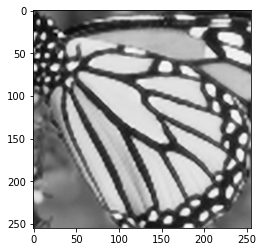

In [14]:
#plot super resolution image
print(SR_image)
print("super resolution image")
plt.imshow(SR_image,cmap='Greys_r')
plt.show()

(255, 255)
Groundtruth image


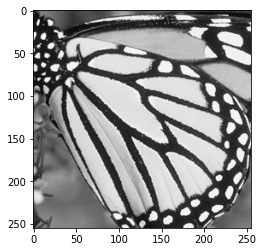

In [15]:
#getting a groundtruth image
groundtruth_image = modcrop(HR_image, 5)
print(groundtruth_image.shape)
#save the groundtruth image
grimg = scipy.misc.imsave('groundtruth_image.jpg',groundtruth_image)
#plot groundtruth image
print("Groundtruth image")
plt.imshow(groundtruth_image,cmap='Greys_r')
plt.show()

In [16]:
#PSNR of high resolution image with bicubic interpolation
print("PSNR of high resolution image with BI")
PSNR1 = peak_signal_noise_ratio(HR_image,LR_image)
print(PSNR1)

PSNR of high resolution image with BI
20.497630181368823


In [17]:
#PSNR of high resolution image with SRCNN
print("PSNR of high resolution image with SRCNN")
PSNR2 = peak_signal_noise_ratio(HR_image,SR_image)
print(PSNR2)

PSNR of high resolution image with SRCNN
22.92269643922954
